In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
import numpy as np
from sklearn.metrics import r2_score
import warnings
import math
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [15]:
df = pd.read_json("data/raw/fics.ndjson", lines = True)
#df = pd.read_json("data/raw/stockfish_150.ndjson", lines = True)
df = df.fillna(0)

print(len(df))
df = df[df['white_cpl'].apply(lambda x: len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: len(x) > 0)]
print(len(df))

25765
25724


In [16]:
print(len(df))
df = df.dropna(subset=['white_elo', 'black_elo'])
print(len(df))
df = df[df['white_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
print(len(df))
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')


df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = df[['white_elo', 'black_elo']].mean(axis=1)
df["diff_elos"] = df['white_elo'] - df['black_elo']

df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

df['stockfish_mean'] = df['stockfish_eval'].apply(np.mean)
df['stockfish_std'] = df['stockfish_eval'].apply(np.std)
df['stockfish_min'] = df['stockfish_eval'].apply(np.min)
df['stockfish_max'] = df['stockfish_eval'].apply(np.max)

dep_var = "mean_elos"

25724
25724
25724


In [5]:
cont = ['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at', 'total_moves', 'end_r',
 'end_p', 'end_b', 'end_n', 'end_q', 'end_N', 'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
 'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean', 'black_std', 'black_min', 'black_max', 'stockfish_mean',
 'stockfish_std', 'stockfish_min', 'stockfish_max']

In [6]:
results = pd.get_dummies(df["result"])
openings = pd.get_dummies(df["Opening"])



X = pd.concat([df[cont], results, openings], axis = 1)
X = X.fillna(0)

num = 20000

y1 = df["mean_elos"]
y2 = df["diff_elos"]

X_train, X_test = X[:num], X[num:]
y1_train, y1_test = df["mean_elos"][:num], df["mean_elos"][num:]
y2_train, y2_test = df["diff_elos"][:num], df["diff_elos"][num:]

In [7]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_mean = RandomForestRegressor(n_estimators=num, n_jobs=-1)
    rf_mean.fit(X_train, y1_train)
    mean_pred_rf = rf_mean.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(mean_absolute_error(y1_test, mean_pred_rf))
    print(r2_score(y1_test, mean_pred_rf))
    print("----------------------------------")

RF model with 30 estimators.
181.35435537123473
0.17167385958675607
----------------------------------


In [11]:
nums = [30, 50, 100, 150, 250, 350]


for num in nums:
    rf_diff = RandomForestRegressor(n_estimators=num, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
    rf_diff.fit(X_train, y2_train)
    dff_pred_rf = rf_diff.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(mean_absolute_error(y2_test, dff_pred_rf))
    print(r2_score(y2_test, dff_pred_rf))
    print("----------------------------------")

RF model with 30 estimators.
127.84984346343364
0.14923236056540523
----------------------------------


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: 

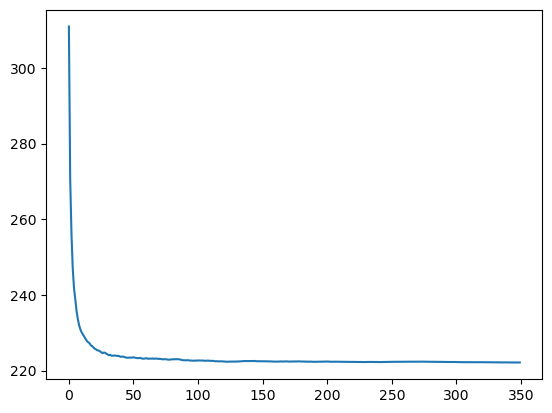

In [212]:
import matplotlib.pyplot as plt
preds = np.stack([t.predict(X_test) for t in rf_mean.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), y1_test) for i in range(350)]);

In [213]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

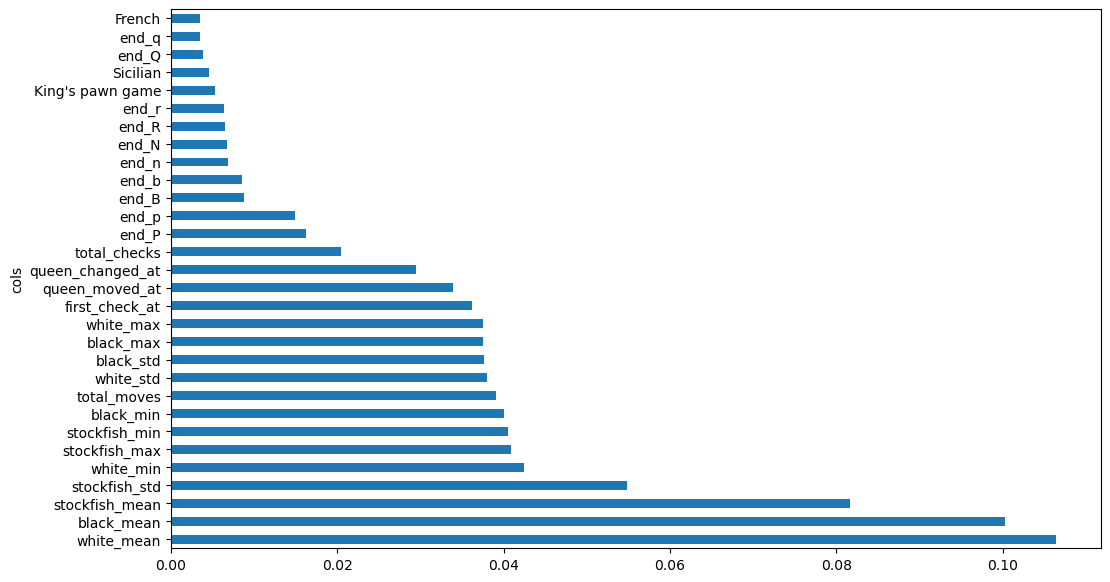

In [219]:
fi = rf_feat_importance(rf_mean, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

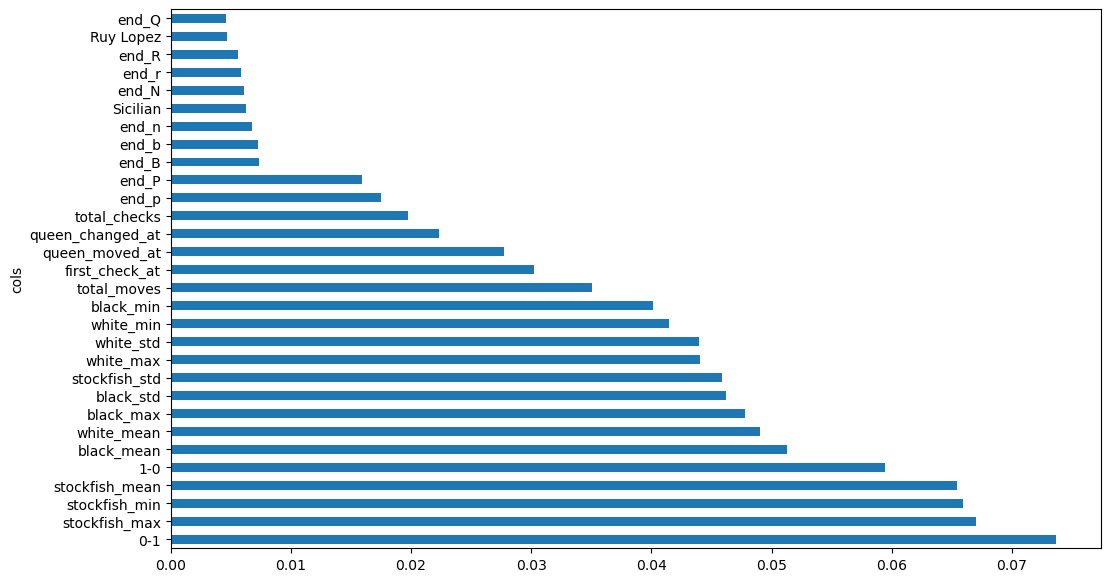

In [220]:
fi = rf_feat_importance(rf_diff, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [229]:
to_keep = fi[fi.imp>0.01].cols
print(len(to_keep))
print((to_keep))

21
29                 0-1
28       stockfish_max
27       stockfish_min
25      stockfish_mean
30                 1-0
21          black_mean
17          white_mean
24           black_max
22           black_std
26       stockfish_std
20           white_max
18           white_std
19           white_min
23           black_min
4          total_moves
2       first_check_at
0       queen_moved_at
3     queen_changed_at
1         total_checks
6                end_p
11               end_P
Name: cols, dtype: object


In [166]:
len(X_test)
len(dff_pred_rf)

5724

In [163]:
white_pred = []
black_pred = []

for i in range(len(dff_pred_rf)):
    white_pred.append(mean_pred_rf[i] + dff_pred_rf[i]/2)
    black_pred.append(mean_pred_rf[i] - dff_pred_rf[i]/2)


all_preds = white_pred + black_pred

In [167]:
len(all_preds)

11448

In [173]:
white_actual = []
black_actual = []
for ind, row in df[num:].iterrows():
    white_actual.append(row["white_elo"])
    black_actual.append(row["black_elo"])

all_actual = white_actual + black_actual

In [174]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(all_actual, all_preds)

193.34092615455324

In [175]:
import matplotlib.pyplot as plt

# Assuming valid_y and pred are your actual and predicted values
# valid_y = [your actual values]
# pred = [your predicted values]

plt.figure(figsize=(8, 8))
plt.scatter((all_actual), (all_preds), edgecolor='k', color='b', alpha=0.5)

# Adding a diagonal line to indicate perfect predictions
plt.plot([min(y1), max(y1)], [min(y1), max(y1)], 'r--')

# Adding titles and labels
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.xlabel('Actual Values (valid_y)')
plt.ylabel('Predicted Values (pred)')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [176]:

print(mean_absolute_error(all_actual, all_preds))
print(r2_score(all_actual, all_preds))

193.34092615455324
0.1744761177194425


In [231]:
import joblib
results = pd.get_dummies(df["result"])
imp_features = ["stockfish_max", "stockfish_min", "stockfish_mean", "black_mean", "white_mean", "black_max", "black_std", "stockfish_std", 
                "white_max", "white_std", "white_min", "black_min", "total_moves", "first_check_at", "queen_moved_at", "queen_changed_at", "total_checks", "end_p", "end_P"]

X = pd.concat([df[imp_features], results], axis = 1)
X = X.fillna(0)

y1 = df["mean_elos"]
y2 = df["diff_elos"]

rf_diff = RandomForestRegressor(n_estimators=350, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_diff.fit(X, y1)

rf_mean = RandomForestRegressor(n_estimators=350, n_jobs=-1)
rf_mean.fit(X, y2)




['rf_diff.pkl']

In [232]:
X.columns

Index(['stockfish_max', 'stockfish_max', 'stockfish_min', 'stockfish_mean',
       'black_mean', 'white_mean', 'black_max', 'black_std', 'stockfish_std',
       'white_max', 'white_std', 'white_min', 'black_min', 'total_moves',
       'first_check_at', 'queen_moved_at', 'queen_changed_at', 'total_checks',
       'end_p', 'end_P', '0-1', '1-0', '1/2-1/2'],
      dtype='object')

In [ ]:

# Save the trained model to a file
joblib.dump(rf_mean, 'rf_mean.pkl')
joblib.dump(rf_diff, 'rf_diff.pkl')